<a href="https://colab.research.google.com/github/vlamen/tue-deeplearning/blob/main/assignments/assignment_1/Assignment_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>    

# Group Number: 28
# Student 1: Stan Meijerink, 1222737
# Student 2: Sam van der Velden, 1017871 
# Student 3: Danylo Vasylyshyn, 1815709


In [1]:
import requests
import io
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
%pylab inline

# can you see this

Populating the interactive namespace from numpy and matplotlib


### Training data set


For Assignment 1 you need to use a specific data set prepared using images from the [Omniglot dataset](https://github.com/brendenlake/omniglot). The provided training data set contains images of handwritten characters of size (28,28). 



For training data, the dataset contains 10000 sets of 6 images each. Each set consists of 5 support images and 1 query image. In each set, the first five columns are support images and the last one is a query image.

For training labels, the dataset contains 10000 sets of 5 binary flags for support images. 1 indicates the same character is given in the query image and 0 means not. For example, a label [1,0,0,1,1] means the support images with index 0,3,4 are the same character of query image.

 
 
The following cell provides code that loads the data from hardcoded URLs.You can use the code in this cell to load the dataset or download the data set from the given URLs to your local drive (or your Google drive) and modify the code to load the data from another location. 




In [2]:
def load_numpy_arr_from_url(url):
    """
    Loads a numpy array from surfdrive. 
    
    Input:
    url: Download link of dataset 
    
    Outputs:
    dataset: numpy array with input features or labels
    """
    
    response = requests.get(url)
    response.raise_for_status()

    return np.load(io.BytesIO(response.content)) 
    
    
    
#Downloading may take a while..
train_data = load_numpy_arr_from_url('https://surfdrive.surf.nl/files/index.php/s/4OXkVie05NPjRKK/download')
train_label = load_numpy_arr_from_url('https://surfdrive.surf.nl/files/index.php/s/oMLFw60zpFX82ua/download')

print(f"train_data shape: {train_data.shape}")
print(f"train_label shape: {train_label.shape}\n")

train_data shape: (10000, 6, 28, 28)
train_label shape: (10000, 5)



Now, we plot the first 5 cases in the training dataset. The last column corresponds with the query images of each task. All other images are support images. The image enclosed in a red box denotes the target image that your model should be able to recognize as the same class as the query image. 

In [3]:
def plot_case(caseID,train_data,labels):
    """
    Plots a single sample of the query dataset
    
    Inputs
    caseID: Integer between 0 and 99, each corresponding to a single sample in the query dataset
    """
    

    support_set,queries = np.split(train_data, [5], axis=1)
    print(queries.shape)
    f, axes = plt.subplots(1, 6, figsize=(20,5))

    # plot anchor image
    axes[5].imshow(queries[caseID, 0])
    axes[5].set_title(f"Query image case {caseID}", fontsize=15)

    # show all test images images 
    [ax.imshow(support_set[caseID, i]) for i, ax in enumerate(axes[0:-1])]


    # Add the patch to the Axes
    for ind in np.where(labels[caseID]==True)[0]:
        axes[ind].add_patch(Rectangle((0,0),27,27,linewidth=2, edgecolor='r',facecolor='none'))


(10000, 1, 28, 28)
(10000, 1, 28, 28)
(10000, 1, 28, 28)
(10000, 1, 28, 28)
(10000, 1, 28, 28)


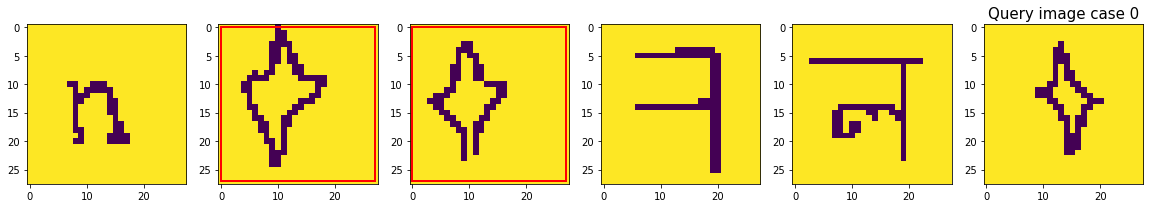

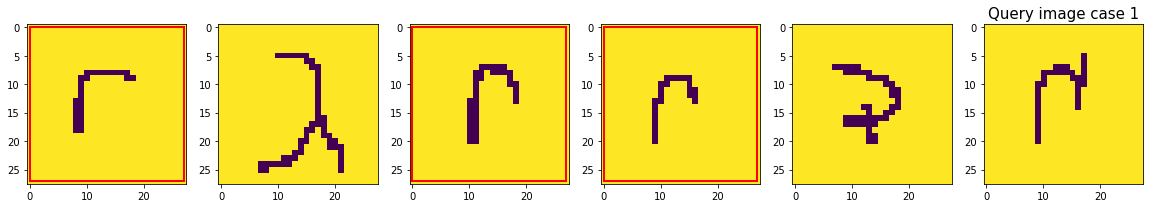

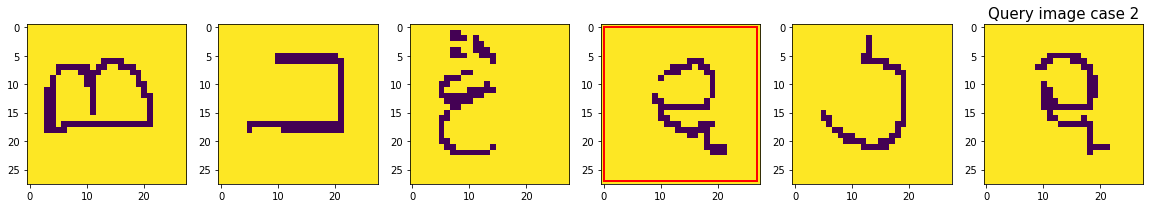

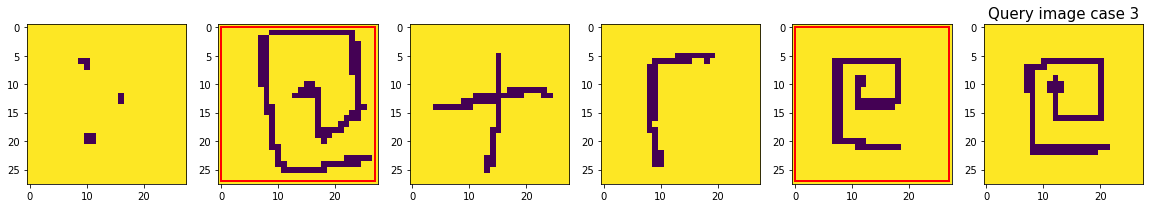

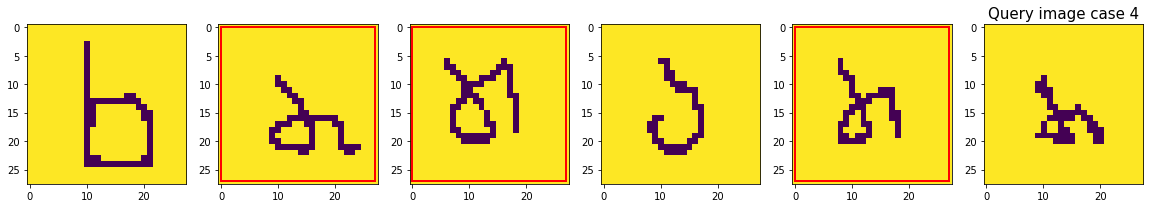

In [ ]:
[plot_case(caseID,train_data,train_label) for caseID in range(5)] ;

### Query data set

For this task you need to use the following query data set. The dataset contains 1000 sets of 6 images each. The images are also of hand written characters, however these characters are not present in the training data set. The characters in the query data set all come from the Greek alphabet that is not part of the set of alphabets in the training data. 


In [4]:
    
#Downloading may take a while..
test_data = load_numpy_arr_from_url('https://surfdrive.surf.nl/files/index.php/s/06c34QVUr69CxWY/download')
test_label = load_numpy_arr_from_url('https://surfdrive.surf.nl/files/index.php/s/LQIH1CW7lfDXevk/download')

print(f"test_data shape: {test_data.shape}")
print(f"test_label shape: {test_label.shape}\n")

test_data shape: (1000, 6, 28, 28)
test_label shape: (1000, 5)



(1000, 1, 28, 28)
(1000, 1, 28, 28)
(1000, 1, 28, 28)
(1000, 1, 28, 28)
(1000, 1, 28, 28)
(1000, 1, 28, 28)
(1000, 1, 28, 28)


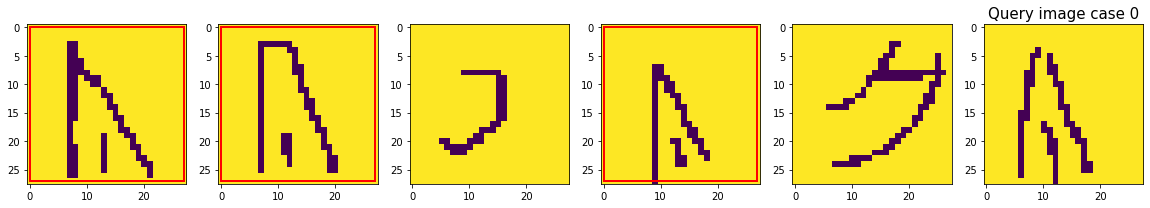

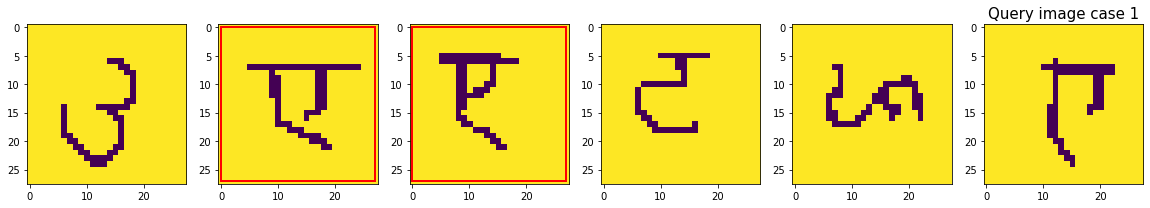

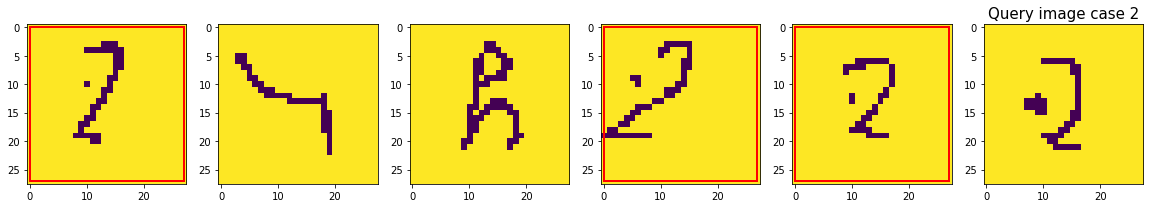

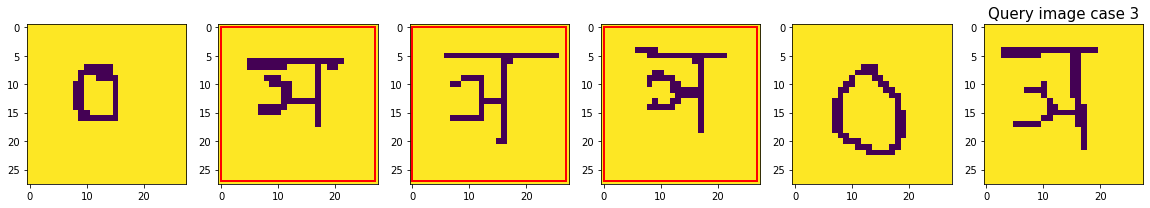

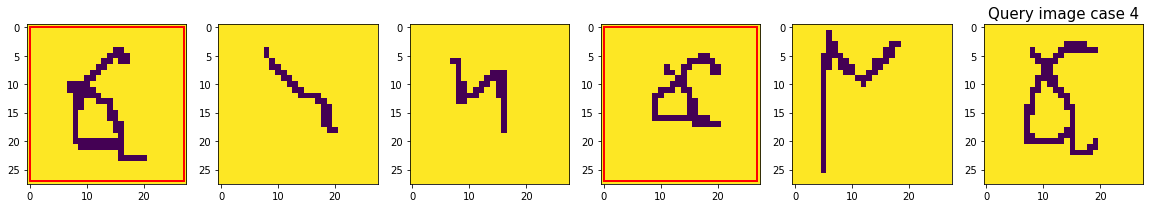

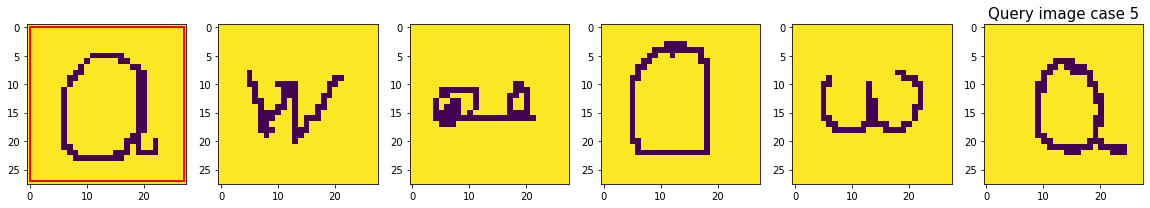

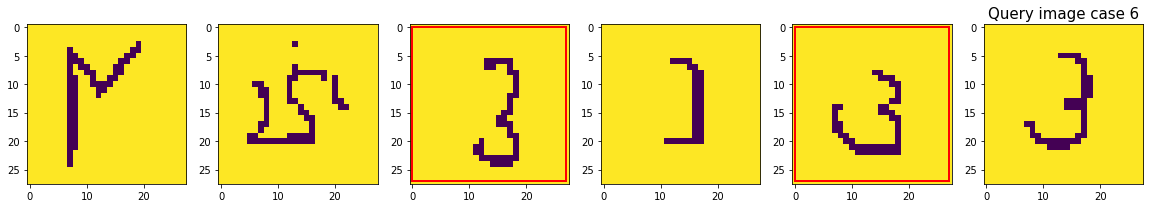

In [ ]:
[plot_case(caseID,test_data,test_label) for caseID in range(7)] ;

### Build pytorch DataSet and DataLoader

In [5]:
import torch
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader,TensorDataset
import numpy as np
from PIL import Image


class MyDataset(Dataset):
    def __init__(self, data, targets):
        self.data = torch.FloatTensor(data)
        self.targets = torch.IntTensor(targets)

        
    def __getitem__(self, index):
        x = self.data[index]
        y = self.targets[index]
        return x, y
    
    def __len__(self):
        return len(self.data)

In [6]:
#creating the datasets
train_dataset=MyDataset(train_data,train_label)
test_dataset=MyDataset(test_data,test_label)

In [7]:
#creating the dataloader
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=1)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1)

## Creating the model
Below we implement the EmbeddingNet. The model takes as an input a batch of images (in a vectorized form) of size N x 1 X D1 x D2, where N is the size of the batch, D1 and D2 are the image dimensions. The network produces as an output a batch of embeddings with size N x L, where L is the dimensions of embedding for an image and N, as previously mentioned, batch size.

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Lambda(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func

    def forward(self, x):
        return self.func(x)


class EmbeddingNet(nn.Module):
    def __init__(self):
        """CNN Builder."""
        super(EmbeddingNet, self).__init__()
        #defining a convolutional neural network
        self.front_layer = nn.Sequential(
          nn.Conv2d(1, 16, kernel_size=5, stride=1, padding=1),
          nn.ReLU(),
          nn.Conv2d(16, 16, kernel_size=5, stride=1, padding=1),
          nn.ReLU(),
          nn.BatchNorm2d(16),
          nn.Conv2d(16, 16, kernel_size=5, stride=1, padding=1),
          nn.ReLU(),
          nn.Conv2d(16, 16, kernel_size=5, stride=1, padding=1),
          nn.ReLU(),
          nn.Conv2d(16, 16, kernel_size=5, stride=1, padding=1),
          nn.AvgPool2d(4),
          Lambda(lambda x: x.view(x.size(0), -1)),
        )

        #setting the last layer to a linear layer to produce embeddings of dimension N x L as mentioned above
        self.last_layer = nn.Linear(256, 150)

        #storing the optimal threshold in the model to use it more easily
        self.threshold = 0

    def forward(self, x):
        """Perform forward."""
        # conv layers
        x = self.front_layer(x)
        x = self.last_layer(x)
        return x
    
    def get_embedding(self, x):
        return self.forward(x)

## Defining loss function
In order to train the model to produce the embeddings we use the triplet loss described in the following paper.<p>
**Triplet loss**:   $L_{triplet}(x_a, x_p, x_n) = max(0, m +  \lVert f(x_a)-f(x_p)\rVert_2^2 - \lVert f(x_a)-f(x_n)\rVert_2^2$\)<p>
We also use one of the enhancements proposed in the paper, which is: out of the negative examples (ones that are different class than the query image) we only choose one that the model produces the worst prediction for, and use it for loss calculation, however all the positive examples are used in this loss calculation.


In [9]:
class TripletLoss(nn.Module):
    """
    Triplets loss
    Takes a batch of embeddings and corresponding labels.
    Triplets are generated using triplet_selector object that take embeddings and targets and return indices of
    triplets
    """

    def __init__(self, margin):
        super(TripletLoss, self).__init__()
        self.margin = margin

    def forward(self, embeddings, target):
        target = target.reshape(-1).cpu()
        anchor_idx = 5 
        
        positive_idx = np.where(target == 1)[0]
        negative_idx = np.where(target == 0)[0]
        closest_negative = (embeddings[negative_idx] - embeddings[anchor_idx]).pow(2).sum(1).argmin()

        #losses calculation:
        #We use the ReLU function as shortcut for max(0, ...) for pytorch
        losses = F.relu((embeddings[positive_idx] - embeddings[anchor_idx]).pow(2).sum(1) - (embeddings[anchor_idx] - embeddings[closest_negative]).pow(2).sum() + self.margin)
        
        #putting it back on cuda
        target = target.cuda()
        return losses.mean()

## Defining the accuracy
Below we define a function that will help us have a meaningful performance metrics for our model. This metrics is accuracy. However to evaluate the accuracy we first need to define a threshold, which will separate positive examples from negative examples (euclidean distance between the embeddings for which the examples under this distance are considered to be of the same class, and over or equal to this distance - a negative class). <p>
We find this threshold the following way:
- Find the positive example in the dataset, with the biggest distance from its query image <b><i>upper_boundary_threshold</i></b>, and the negative example in the dataset with the closest distance to the query image <b><i>lower_boundary_threshold</i></b>.
- Iterate over the range between the two above-mentioned values (<b><i>lower_boundary_threshold</i></b> and <b><i>upper_boundary_threshold</i></b>) with some little step size (in this case splitting the range into 1000 equal steps) and calculating the accuracy by setting the threshold to the current value in the iteration. The optimal threshold is the one that maximizes accuracy. We only select values in the given range, because for values out of it, we would get an increase in false positive rate without decreasing the false negative rate or the opposite - increase in the false negative rate without the decrease in false positive rate.

In [10]:
def optimal_accuracy(all_predictions, all_targets):
  distances = (all_predictions[:, 0:5] - all_predictions[:, 5:6, :]).pow(2).sum(2)
  #finding the furthest positive example:
  upper_boundary_threshold = torch.masked_select(distances, torch.where(all_targets > 0.5, True, False)).max()
  #finding the closest negative example
  lower_boundary_threshold = torch.masked_select(distances, torch.where(all_targets < 0.5, True, False)).min()
  best_threshold, best_accuracy = 0, 0
  for threshold in torch.linspace(lower_boundary_threshold, upper_boundary_threshold, 1000):
    result_mask = torch.where(distances < threshold, 1, 0)
    accuracy = (result_mask == all_targets).sum() / all_targets.numel()
    if accuracy > best_accuracy:
      best_accuracy = accuracy
      best_threshold = threshold
  return best_accuracy, best_threshold

## Training the model

In [11]:
import numpy as np
from tqdm import tqdm


class Trainer():
    def __init__(self,
                 model: torch.nn.Module,
                 device: torch.device,
                 criterion: torch.nn.Module,
                 optimizer: torch.optim.Optimizer,
                 training_DataLoader: torch.utils.data.Dataset,
                 validation_DataLoader: torch.utils.data.Dataset ,
                 epochs: int
                 ):
        
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.training_DataLoader = training_DataLoader
        self.validation_DataLoader = validation_DataLoader
        self.device = device
        self.epochs = epochs
        




    def run_trainer(self):
        for epoch in tqdm(range(self.epochs)):
            self.model.train()  # train mode

            train_losses=[]
            for batch in self.training_DataLoader:
                x,y=batch
                input, target = x.to(self.device), y.to(self.device)  # send to device (GPU or CPU)
                self.optimizer.zero_grad()  # zerograd the parameters
                out = self.model(input.permute(1, 0, 2, 3))  # one forward pass
                
                
                loss = self.criterion(out, target)  # calculate loss
                 
                loss_value = loss.item()
                train_losses.append(loss_value)
                 
                loss.backward()  # one backward pass
                self.optimizer.step()  # update the parameters



            self.model.eval()  # evaluation mode
            valid_losses = []  # accumulate the losses here
            all_predictions = torch.empty((1, *(out.shape)), device = device)
            all_targets = torch.empty((1, 5), device=device)

            for batch in self.validation_DataLoader:

                x,y=batch
                input, target = x.to(self.device), y.to(self.device)  # send to device (GPU or CPU)

                with torch.no_grad():
                    out = self.model(input.permute(1, 0, 2, 3))   # one forward pass
                    all_predictions = torch.cat((all_predictions, out.expand((1, -1, -1))))
                    all_targets = torch.cat((all_targets, target))
                    loss = self.criterion(out, target) # calculate loss
                 
                    loss_value = loss.item()
                    valid_losses.append(loss_value)

            #Evaluating model accuracy after on the validation set after the epoch
            accuracy, threshold = optimal_accuracy(all_predictions, all_targets)

            model.threshold = threshold
            # print the results
            print(
                f'EPOCH: {epoch+1:0>{len(str(self.epochs))}}/{self.epochs}',
                end=' '
            )
            print(f'LOSS: {np.mean(train_losses):.4f}',end=' ')
            print(f'VAL-LOSS: {np.mean(valid_losses):.4f}',end=' ')
            print(f'ACCURACY: {accuracy}',end=' ')
            print(f'THRESHOLD: {threshold}',end='\n')

In [15]:
# # device
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device=torch.device('cpu')
# device=torch.device('cuda')    
print('device:', device)
    
# model
embedding_net = EmbeddingNet()
model = embedding_net.to(device)

# margin value
margin=0.2

# criterion
criterion = TripletLoss(margin)
# optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# trainer
trainer = Trainer(model=model,
                  device=device,
                  criterion=criterion,
                  optimizer=optimizer,
                  training_DataLoader=train_loader,
                  validation_DataLoader=test_loader,
                  epochs=7)

# start training
trainer.run_trainer()

device: cuda


 14%|█▍        | 1/7 [00:35<03:33, 35.64s/it]

EPOCH: 1/7 LOSS: 0.1257 VAL-LOSS: 0.1117 ACCURACY: 0.8801198601722717 THRESHOLD: 0.38030117750167847


 29%|██▊       | 2/7 [01:11<02:58, 35.70s/it]

EPOCH: 2/7 LOSS: 0.1039 VAL-LOSS: 0.1042 ACCURACY: 0.9074925184249878 THRESHOLD: 0.49225178360939026


 43%|████▎     | 3/7 [01:46<02:22, 35.57s/it]

EPOCH: 3/7 LOSS: 0.0980 VAL-LOSS: 0.1022 ACCURACY: 0.9060938954353333 THRESHOLD: 0.455739289522171


 57%|█████▋    | 4/7 [02:22<01:46, 35.53s/it]

EPOCH: 4/7 LOSS: 0.0940 VAL-LOSS: 0.1050 ACCURACY: 0.9054945111274719 THRESHOLD: 0.5430794358253479


 71%|███████▏  | 5/7 [02:57<01:10, 35.50s/it]

EPOCH: 5/7 LOSS: 0.0917 VAL-LOSS: 0.1001 ACCURACY: 0.905694305896759 THRESHOLD: 0.4903961420059204


 86%|████████▌ | 6/7 [03:33<00:35, 35.48s/it]

EPOCH: 6/7 LOSS: 0.0896 VAL-LOSS: 0.1005 ACCURACY: 0.9114884734153748 THRESHOLD: 0.5981512069702148


100%|██████████| 7/7 [04:08<00:00, 35.51s/it]

EPOCH: 7/7 LOSS: 0.0867 VAL-LOSS: 0.1031 ACCURACY: 0.9088910818099976 THRESHOLD: 0.7465351223945618


## Visualizing the results
Below we see the predictions of the neural network, where the images with a red frame - are those identified by the model as positive examples.

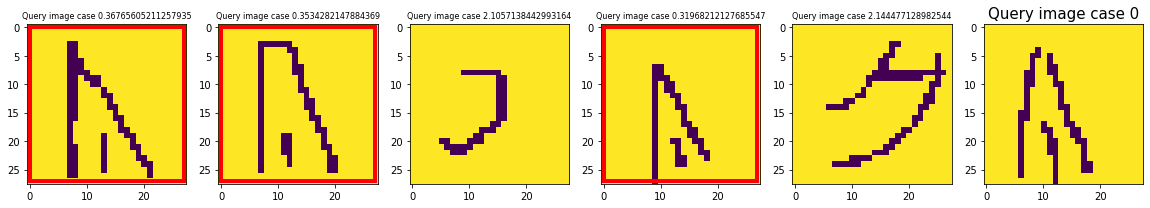

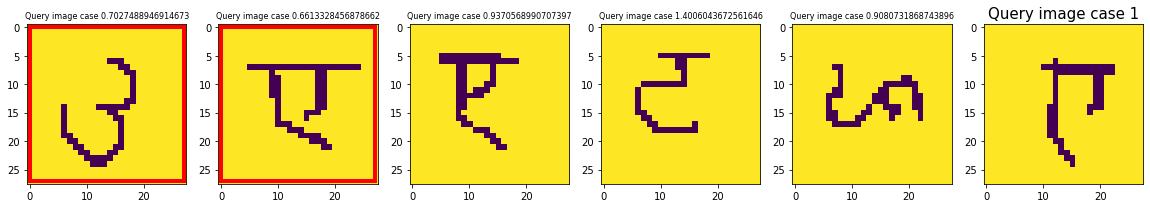

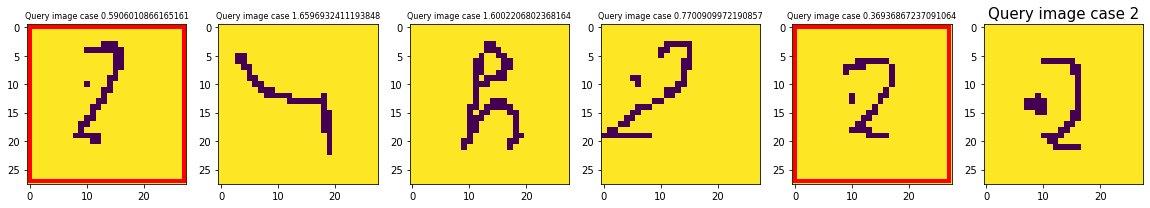

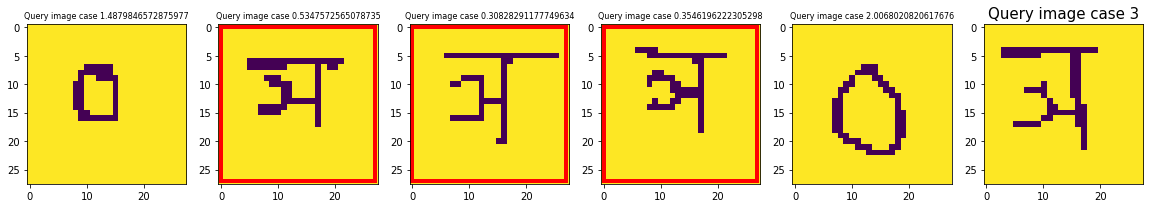

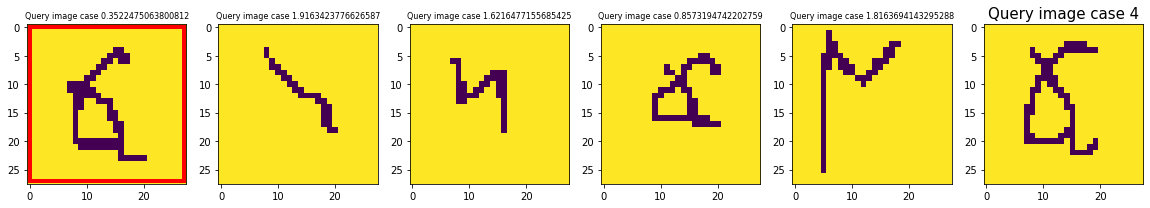

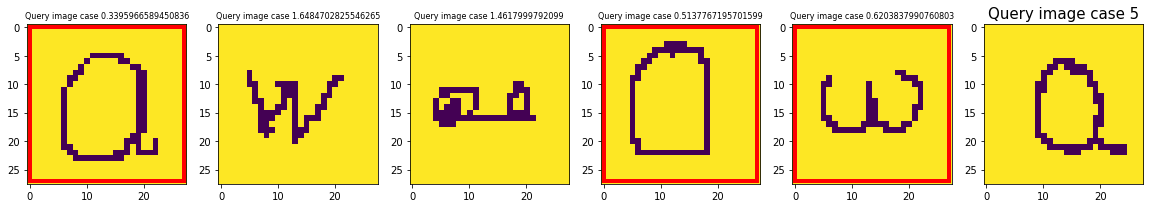

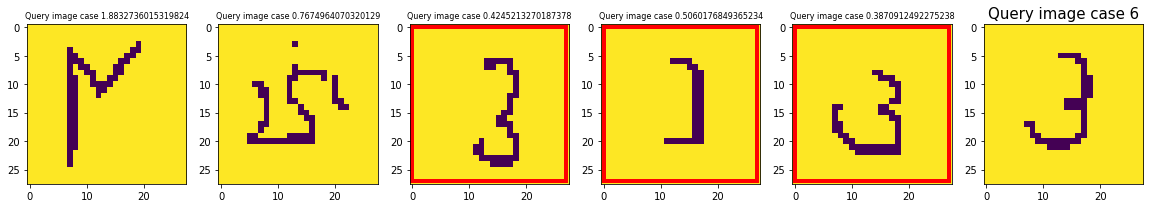

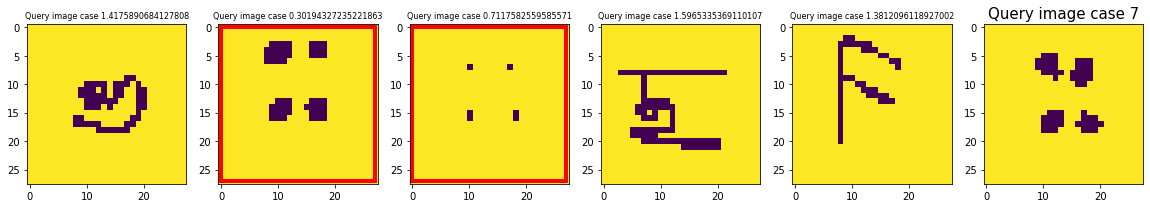

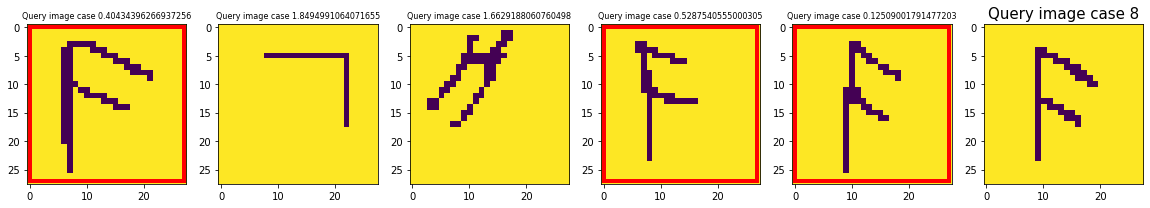

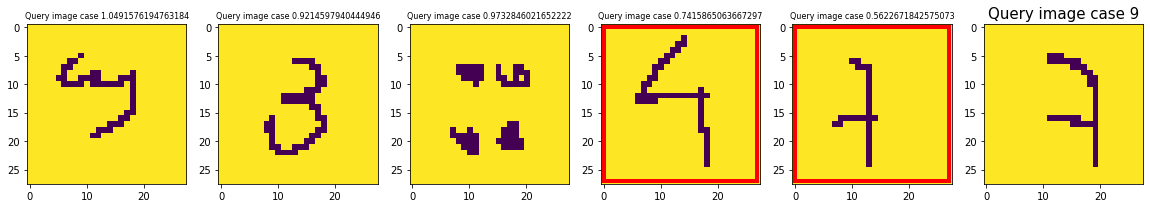

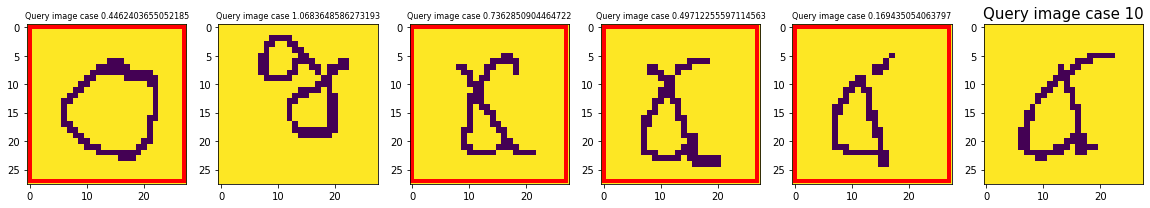

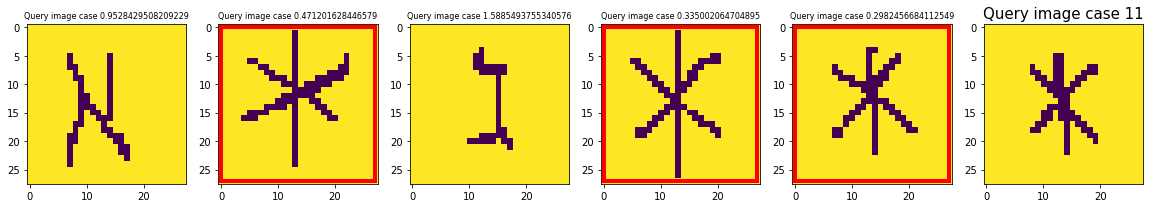

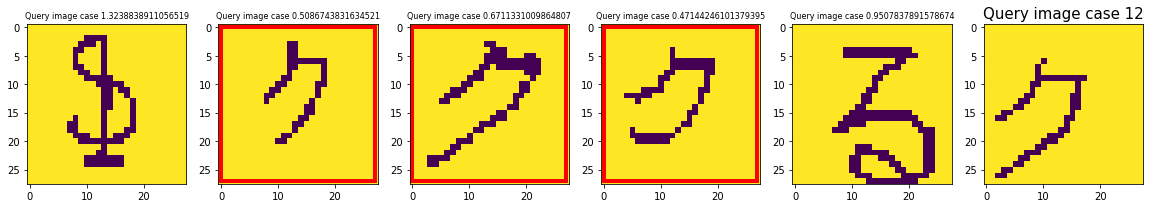

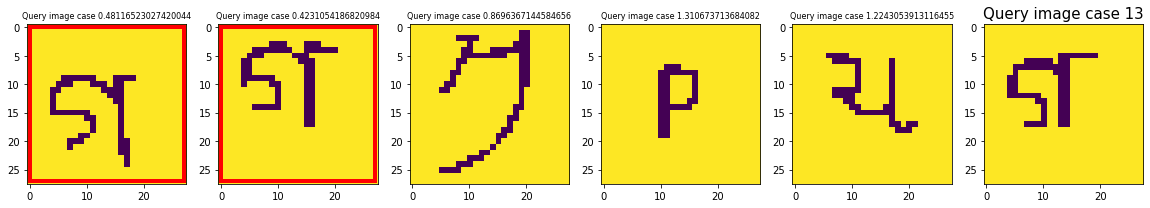

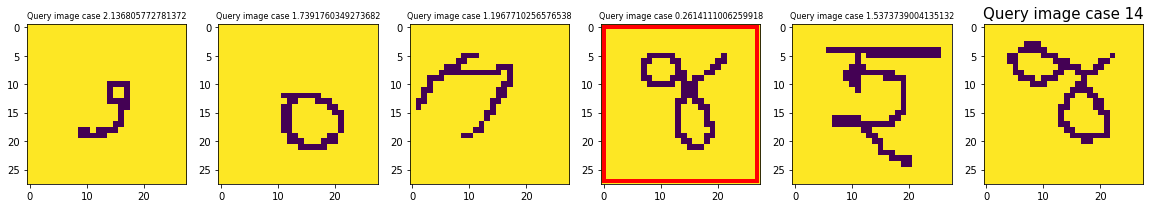

In [16]:
def plot_case_test(caseID,train_data,labels):
    set_of_images = iter(test_loader)
    for i in range(caseID):
      x, y = next(set_of_images)
      x = x.permute(1, 0, 2, 3)
      model.cpu()
      results = model(x)  

      f, axes = plt.subplots(1, 6, figsize=(20,5))

      # plot anchor image
      axes[5].imshow(x[5, 0])
      axes[5].set_title(f"Query image case {i}", fontsize=15)

      # show all test images images 
      [ax.imshow(x[i, 0]) for i, ax in enumerate(axes[0:-1])]


      # Add the patch to the Axes
      for i in range(5):
        dist = (results[5] - results[i]).pow(2).sum()
        axes[i].set_title(f"Query image case {dist}", fontsize=8)

        #Put a frame around the picture if the distance between the embeddings of it and the anchor image
        #are below the calculated threshold.
        if(dist < model.threshold):
          axes[i].add_patch(Rectangle((0,0),27,27,linewidth=4, edgecolor='r',facecolor='none'))


plot_case_test(15,test_data,test_label)